In [1]:
%pylab inline
from collections import OrderedDict
import os
import pandas as pd
from riboraptor.ribocode_utils import wilcoxon_greater, extract_frame,  test_frame
from riboraptor.coherence import coherence

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')


Populating the interactive namespace from numpy and matplotlib


In [2]:
assembly_common_name_map = {'mm10': 'mouse', 'hg38': 'human'}

sheet_name = 'hg38'
excel_df = pd.read_excel('../data/datasets_info.xlsx', sheet_name=sheet_name)


In [3]:
excel_df.head()

,GEO,SRA,RIBO sample,RNA sample,read lengths,offsets,RIBO adapter,RNA adapter,RIBO strandedness,RNA strandedness,AUC(RiboCop/RiboCode/RiboTaper/ORFscore),metagene_coherence_ribocop
0,GSE35469,SRP010679,SRX118286,SRX118285,"28,29,30","12,13,13",CTGTAGGCAC,CTGTAGGCAC,forward,forward,NaN,NaN
1,NaN,SRP029589,SRX345309,SRX345311,"29,30,32","12,12,13",CTGTAGGCACCATCAAT,CTGTAGGCACCATCAAT,forward,forward,NaN,NaN
2,GSE73136,SRP063852,SRX1254413,"SRX426378 (SRP028887, GSE49831)","28,29,30","12,12,12",None,None,forward,forward,NaN,NaN
3,GSE94454,SRP098789,SRX2536421,SRX2536426,"28,30","12,13",CTGTAGGCACCATCAAT,CTGTAGGCACCATCAAT,forward,forward,NaN,NaN
4,GSE96716,SRP102021,SRX2647167,SRX2647164,"28,29,30,31","12,12,12,12",TCGTATGCCGTCTTCTGCTTG,None,forward,forward,NaN,NaN


In [4]:
root_dir = '/staging/as/wenzhenl/re-ribo-analysis/'

In [5]:
def read_coverage_tsv(fp, read_lengths=None):
    df = pd.read_table(fp, header=None)

    df.columns =  ['read_length', 'offset', 'coverage']
    coverages = OrderedDict()
    if read_lengths is None:
        read_lengths = sorted(df.read_length.unique())

    for read_length in read_lengths:
        try:
            df_subset = df[df.read_length==read_length].iloc[0]
        except IndexError:
            print ('IndexError: {} | fp: {} | read_length: {}'.format(df[df.read_length==read_length], fp, read_length))
            raise

        coverage = eval(df_subset.coverage)
        coverage = pd.Series(coverage, index=np.arange(-df_subset.offset, len(coverage)-df_subset.offset))
        coverages[read_length]  = coverage
    return coverages

def get_coherence_and_wilcox_results(coverage):
    coh = coherence(coverage)
    
    

In [6]:
COH_CUTOFF = 0.428
PVAL_CUTOFF = 0.05
#rna_rna = 0
#rna_ribo = 0
#ribo_rna = 0
#ribo_ribo = 0
data = []
for index, row in excel_df.iterrows():
    srp = row['SRA']
    rna_srx = row['RNA sample'].strip().split(' ')[0]
    ribo_srx = row['RIBO sample'].strip().split(' ')[0]
    offsets = list(map(lambda x: int(x.strip()), row['offsets'].split(',')))    
    
    read_lengths = list(map(lambda x: int(x.strip()), row['read lengths'].split(',')))
    read_lengths_offsets = dict(zip(read_lengths, offsets))
    
    rna_tsv_fp = os.path.join(root_dir,
                              '{}_{}'.format(srp, assembly_common_name_map[sheet_name]), 
                              'mapped', 
                              'orfs', 
                              '{}_metagene_profiles_5p.tsv'.format(rna_srx))
    ribo_tsv_fp = os.path.join(root_dir,
                               '{}_{}'.format(srp, assembly_common_name_map[sheet_name]), 
                               'mapped',
                               'orfs',
                               '{}_metagene_profiles_5p.tsv'.format(ribo_srx))
    
    if not os.path.isfile(rna_tsv_fp):
        print('Missing {}'.format(rna_tsv_fp))
        continue
    
    if not os.path.isfile(ribo_tsv_fp):
        print('Missing {}'.format(ribo_tsv_fp))
        continue
    try:
        rna_coverages = read_coverage_tsv(rna_tsv_fp)
    except pd.errors.EmptyDataError:
        print ('EmptyDataError: {}'.format(rna_tsv_fp))
        continue
    rna_coherences = OrderedDict()
    rna_pvals = OrderedDict()
    
    for read_length in rna_coverages.keys():
        rna_coverages[read_length] = np.array(rna_coverages[read_length].values)
        coh = coherence(rna_coverages[read_length])[0]
        rna_coherences[read_length] = coh
        pval = test_frame(*extract_frame(rna_coverages[read_length]))[2]
        pval = test_frame(*extract_frame(rna_coverages[read_length]))[2]
        rna_pvals[read_length] = pval
        
        ribocop_prediction = 'rna'
        ribocode_prediction = 'rna'
        
        if coh > COH_CUTOFF:
            ribocop_prediction = 'ribo'
        
        if pval < PVAL_CUTOFF:
            ribocode_prediction = 'ribo'
        
            
        
        data.append((srp, rna_srx, 'rna', read_length, coh, ribocop_prediction, pval, ribocode_prediction))
    try:
        ribo_coverages = read_coverage_tsv(ribo_tsv_fp, read_lengths)
    except pd.errors.EmptyDataError:
        print ('EmptyDataError: {}'.format(ribo_tsv_fp))
        continue
        
    ribo_coherences = OrderedDict()
    ribo_pvals = OrderedDict()
    
    for read_length in ribo_coverages.keys():
        offset = read_lengths_offsets[read_length]        
        max_index = ribo_coverages[read_length].index.max()
        ribo_coverages[read_length] = ribo_coverages[read_length][np.arange(-offset, max_index)]
        ribo_coverages[read_length] = np.array(ribo_coverages[read_length].values)
        coh = coherence(ribo_coverages[read_length])[0]
        pval = test_frame(*extract_frame(ribo_coverages[read_length]))[2]
        rna_coherences[read_length] = coh
        ribo_pvals[read_length] = pval
        ribocop_prediction = 'rna'
        ribocode_prediction = 'rna'
        
        if coh > COH_CUTOFF:
            ribocop_prediction = 'ribo'
        
        if pval < PVAL_CUTOFF:
            ribocode_prediction = 'ribo'
        
        data.append((srp, rna_srx, 'ribo', read_length, coh, ribocop_prediction, pval, ribocode_prediction))

Missing /staging/as/wenzhenl/re-ribo-analysis/SRP063852_human/mapped/orfs/SRX426378_metagene_profiles_5p.tsv


In [7]:
summary_df = pd.DataFrame(data)
summary_df.columns = ['srp', 'srx', 'assay', 'read_length', 'ribocop_coherence', 'ribocop_prediction', 'ribocode_pval', 'ribocode_prediction']

In [8]:
summary_df.to_csv('./results/{}_ribocop_ribocode_summary.tsv'.format(assembly_common_name_map[sheet_name]), header=True, index=False, sep='\t')

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes usi

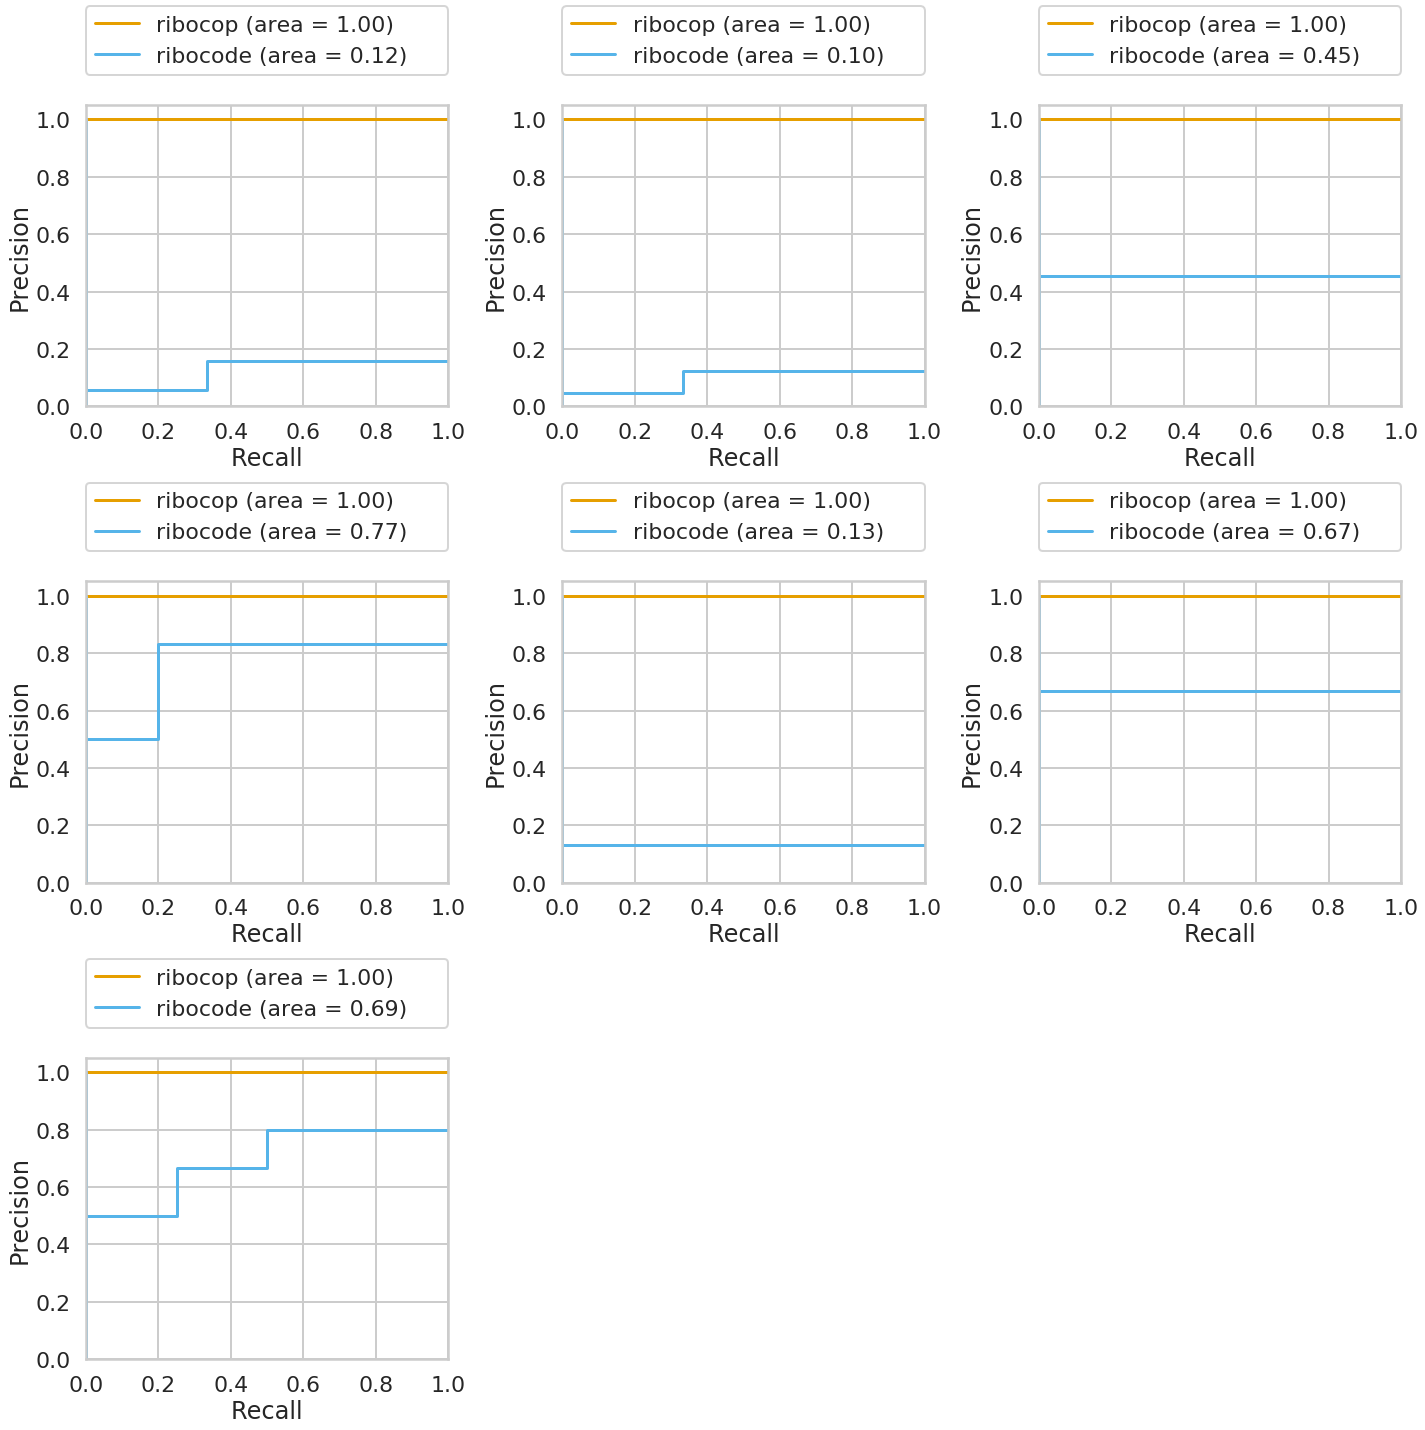

In [9]:

n_groups = len(summary_df.groupby('srp'))
cbb_palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

def _plot_aurpr(y_test, y_score, ax, label, color):
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    auprc = average_precision_score(y_test, y_score)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    ax = plt.subplot(n_groups/2, n_groups/2, plot_num)
    ax.step(recall, precision, color=color, lw=3,
             where='post', label='{} (area = {:.2f})'.format(label, auprc))
    #ax.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    #ax.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
    #          average_precision))
    #ax.legend(loc="lower right")
    ax.legend(bbox_to_anchor=(0,1.1,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)

def _plot_auroc(y_test, y_score, ax, label, color):
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    ax.plot(fpr, tpr, color=color,
             lw=lw, label='{} (area = {:.2f})'.format(label, roc_auc))
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    #ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(0,1.1,1,0.2), loc="lower left",
              mode="expand", borderaxespad=0, ncol=1)
plot_num = 1
fig = plt.figure(figsize=(20, 20))    
for key, group in summary_df.groupby('srp'):
    rna = group[group.assay=='rna']
    ribo = group[group.assay=='ribo']
    group['label'] = 0
    group.loc[group['assay']=='ribo', 'label'] = 1
    y_test = group['label']
    y_score = group['ribocop_coherence']
    ax = plt.subplot(3, 3, plot_num)
    _plot_aurpr(y_test, y_score, ax, 'ribocop', cbb_palette[1])
    y_test = group['label']
    y_score = group['ribocode_pval']
    _plot_aurpr(y_test, y_score, ax, 'ribocode', cbb_palette[2])
    
    ax.set_title(key)
    plot_num += 1
fig.tight_layout()
fig.savefig('./results/{}_ribocop_ribocode_auPRC.pdf'.format(assembly_common_name_map[sheet_name]))

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


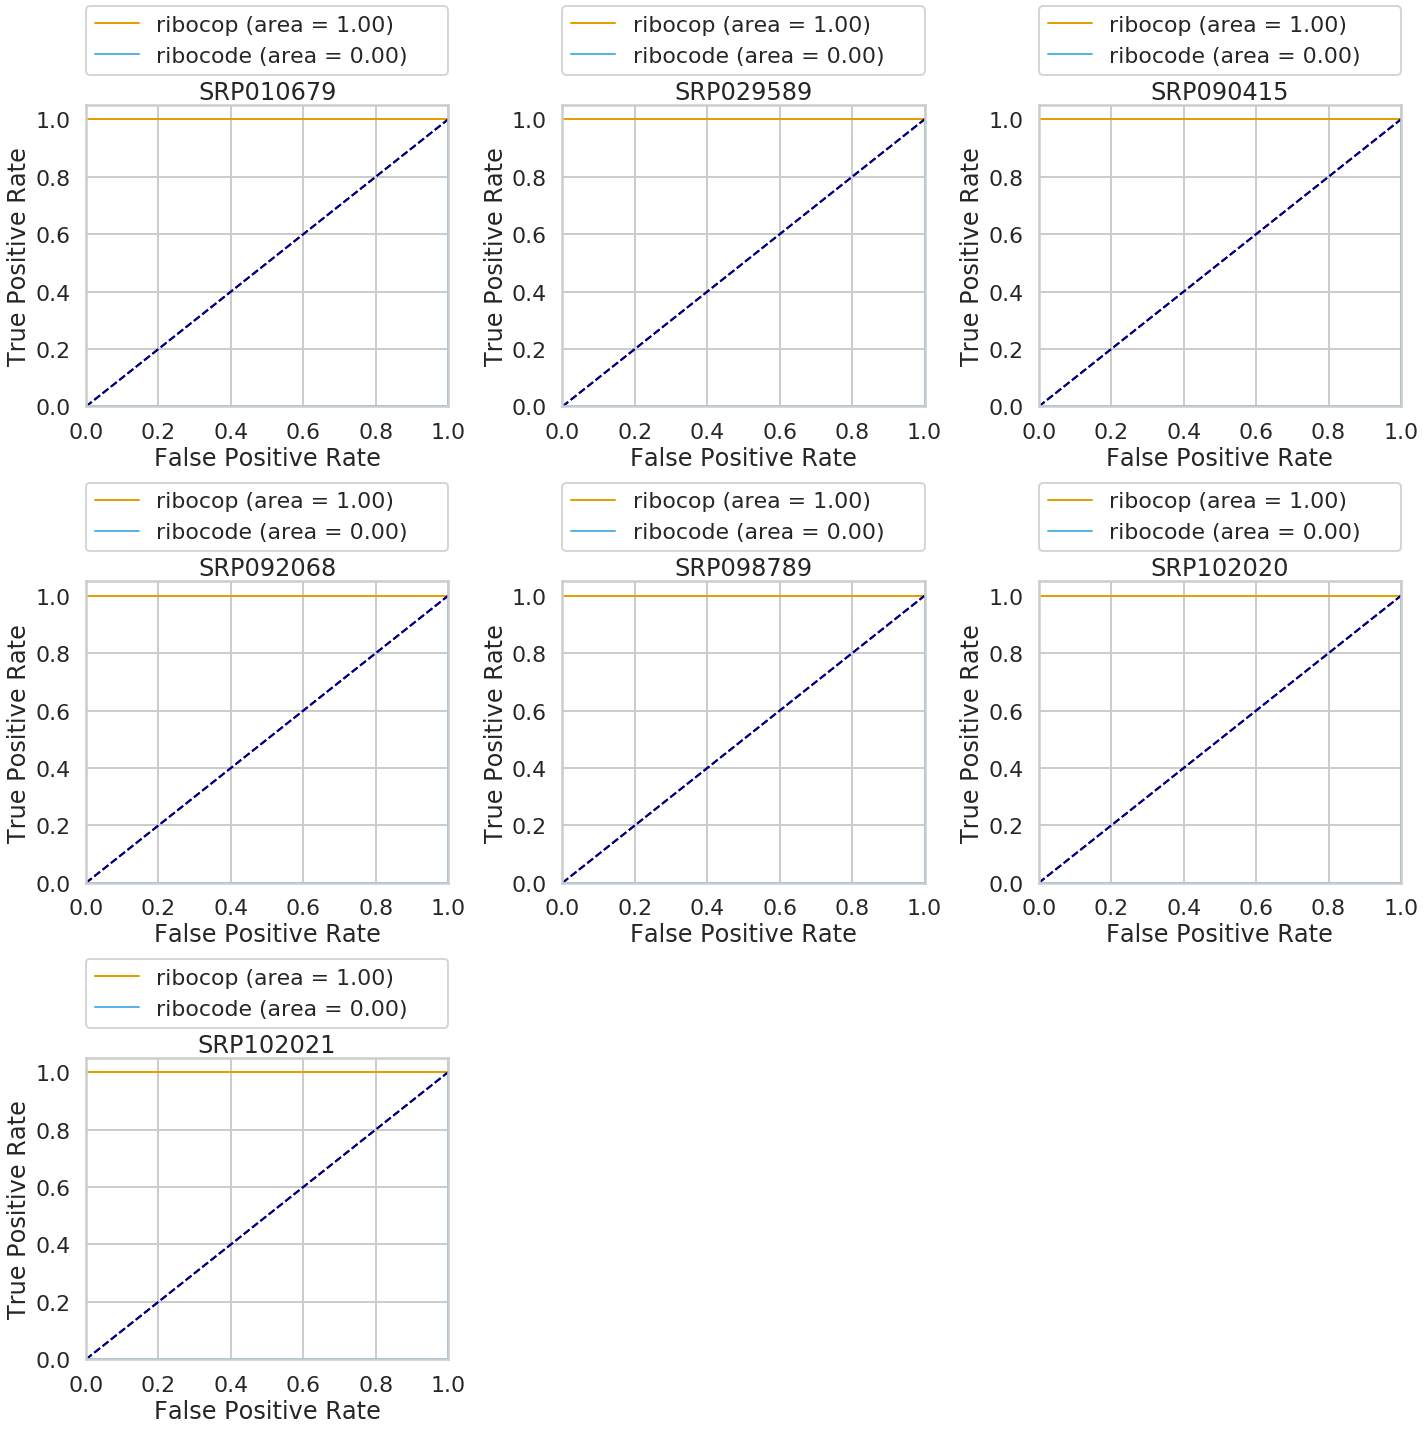

In [10]:
plot_num = 1
fig = plt.figure(figsize=(20, 20))    
for key, group in summary_df.groupby('srp'):
    rna = group[group.assay=='rna']
    ribo = group[group.assay=='ribo']
    
    group['label'] = 0
    group.loc[group['assay']=='ribo', 'label'] = 1
    
    y_test = group['label']
    y_score = group['ribocop_coherence']
    ax = plt.subplot(3, 3, plot_num)
    _plot_auroc(y_test, y_score, ax, 'ribocop', cbb_palette[1])
    
    y_test = group['label']
    y_score = group['ribocode_pval']
    _plot_auroc(y_test, y_score, ax, 'ribocode', cbb_palette[2])
    
    ax.set_title(key)
    plot_num += 1
fig.tight_layout()
fig.savefig('./results/{}_ribocop_ribocode_auROC.pdf'.format(assembly_common_name_map[sheet_name]))

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          ax=None,
                          cmap=plt.cm.Blues):
    sns.set_style('white')
    sns.set_context('poster')
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.title(title)
    #ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    

# Total counts 

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


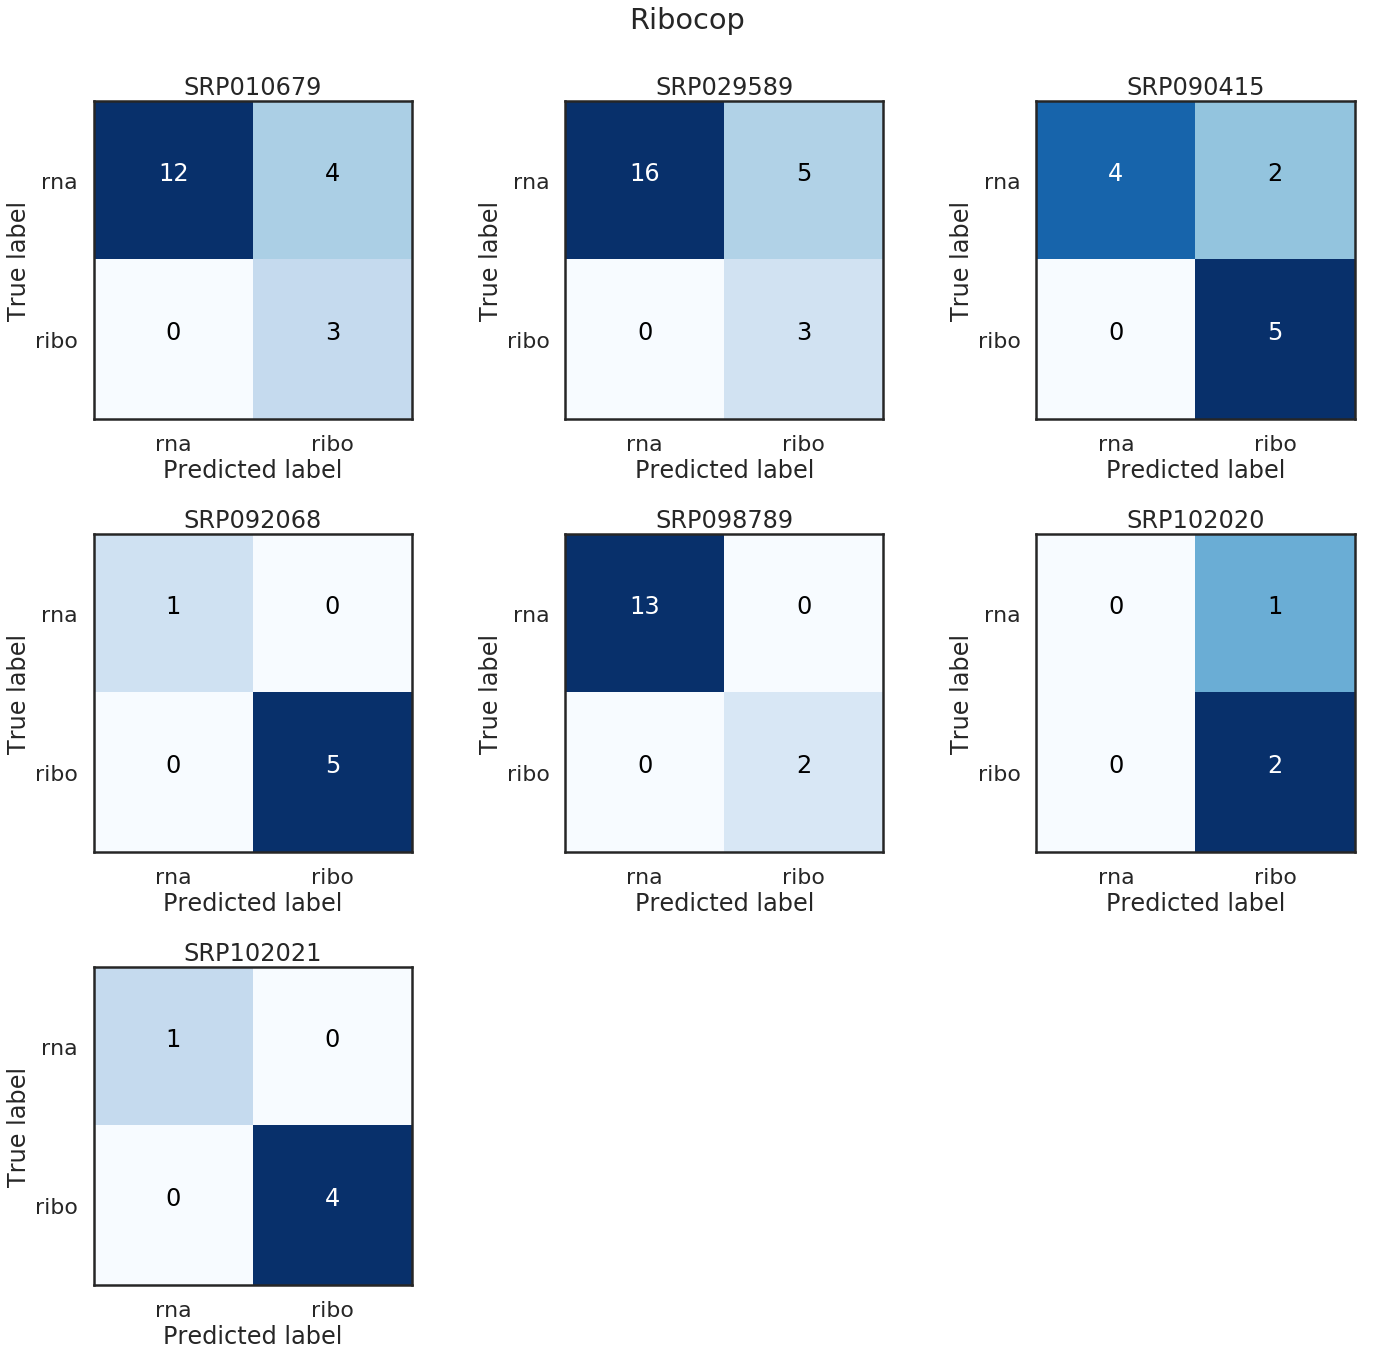

In [19]:
confusion_matrices = []
plot_num = 1
fig = plt.figure(figsize=(20, 20))    
class_names = ['rna', 'ribo']
for key, group in summary_df.groupby('srp'):
    rna = group[group.assay=='rna']
    ribo = group[group.assay=='ribo']
    
    rna_total = rna.shape[0]
    ribo_total = ribo.shape[0]
    
    group['label'] = 0
    group['ribocop_label'] = 0
    group['ribocode_label'] = 0
    
    group.loc[group['assay']=='ribo', 'label'] = 1
    group.loc[group['ribocop_prediction']=='ribo', 'ribocop_label'] = 1
    group.loc[group['ribocode_prediction']=='ribo', 'ribocode_label'] = 1
    
    
    """
    rna_as_rna = np.sum(rna['assay'] == rna['ribocop_prediction'])   
    rna_as_ribo = rna_total - rna_as_rna
    
    ribo_as_ribo = np.sum(ribo['assay'] == rna['ribocop_prediction'])
    ribo_as_rna = ribo_total - ribo_as_ribo
    """
    cnf_matrix = confusion_matrix(group['label'], group['ribocop_label'])
    ax = plt.subplot(3, 3, plot_num)
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, ax=ax,
                      title='Confusion matrix, without normalization')
    ax.set_title(key)
    plot_num += 1
fig.suptitle('Ribocop')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.savefig('./results/{}_ribocop_confusion_matrix.pdf'.format(assembly_common_name_map[sheet_name]))

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


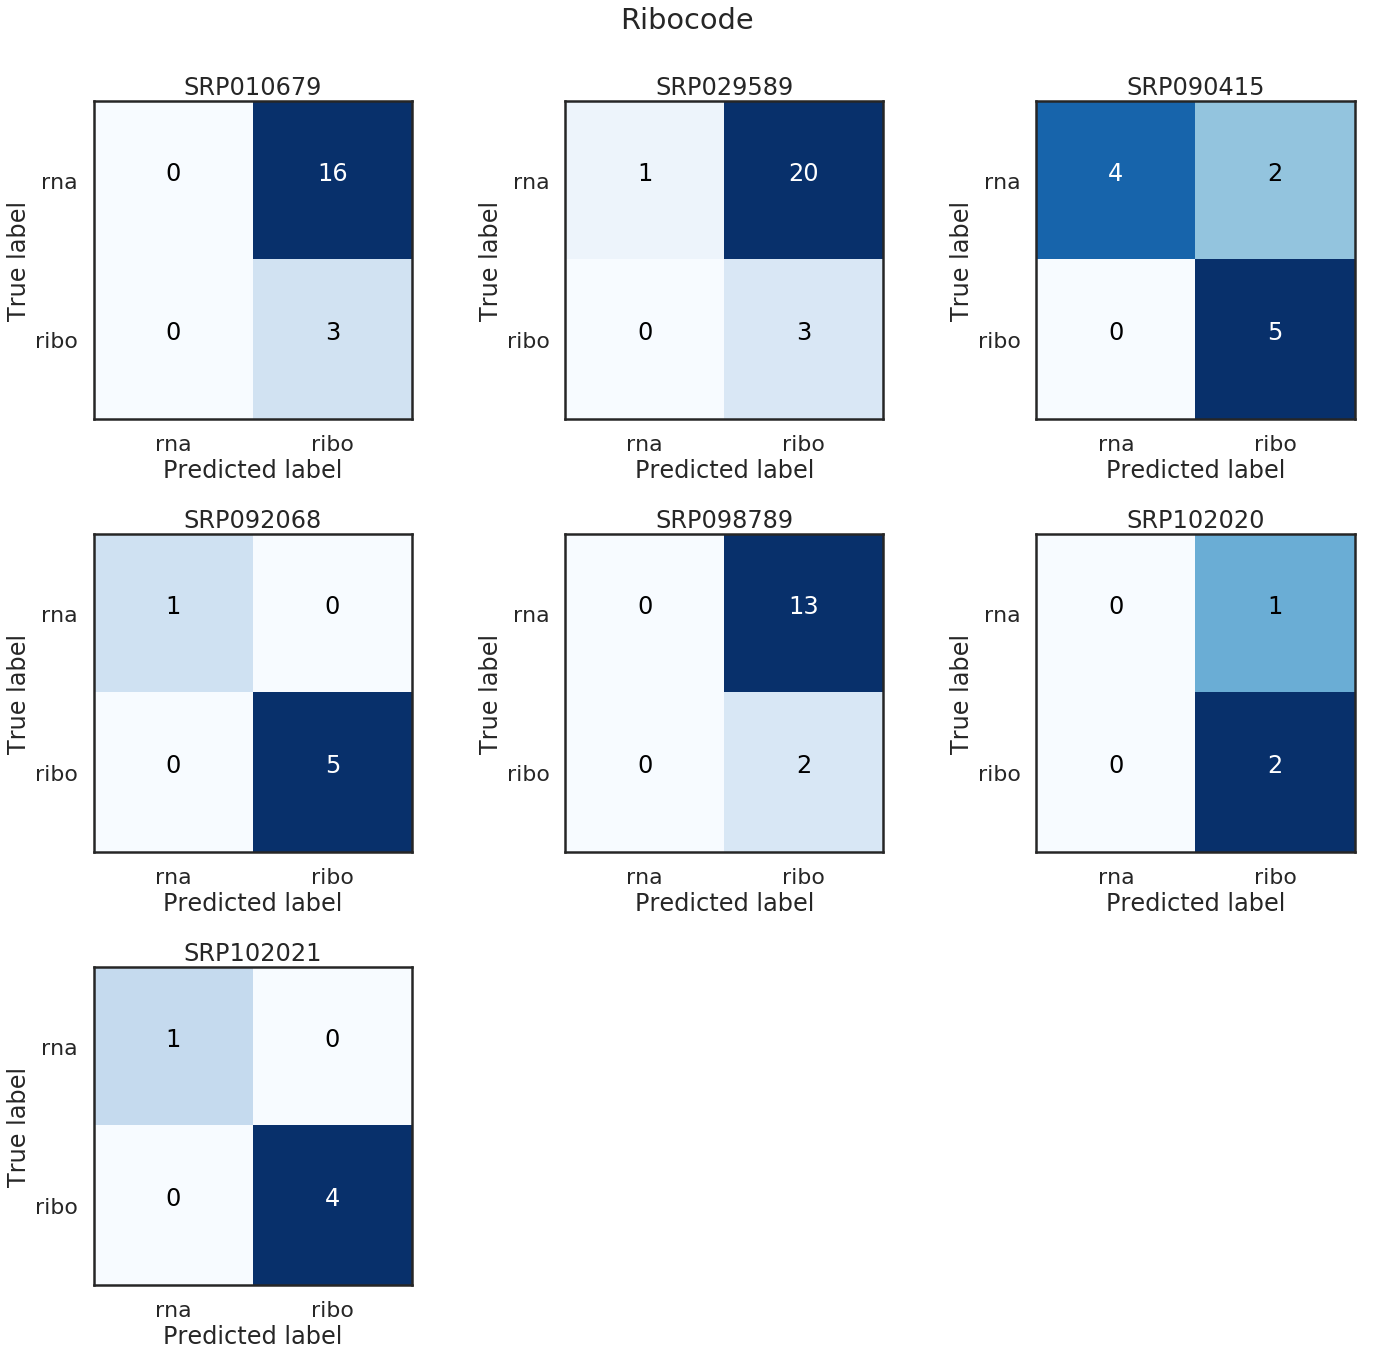

In [18]:
confusion_matrices = []
plot_num = 1
fig = plt.figure(figsize=(20, 20))    
for key, group in summary_df.groupby('srp'):
    rna = group[group.assay=='rna']
    ribo = group[group.assay=='ribo']
    
    rna_total = rna.shape[0]
    ribo_total = ribo.shape[0]
    
    group['label'] = 0
    group['ribocop_label'] = 0
    group['ribocode_label'] = 0
    
    group.loc[group['assay']=='ribo', 'label'] = 1
    group.loc[group['ribocop_prediction']=='ribo', 'ribocop_label'] = 1
    group.loc[group['ribocode_prediction']=='ribo', 'ribocode_label'] = 1
    
    cnf_matrix = confusion_matrix(group['label'], group['ribocode_label'])
    ax = plt.subplot(3, 3, plot_num)
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, ax=ax,
                      title='Confusion matrix, without normalization')
    ax.set_title(key)
    plot_num += 1
    

fig.suptitle('Ribocode')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.savefig('./results/{}_ribocode_confusion_matrix.pdf'.format(assembly_common_name_map[sheet_name]))

In [ ]:
1579133 2213781 3146339 4129449 5833534 6915938 7792405 8362269 9504657 0433204